<a href="https://colab.research.google.com/github/animesh-77/Active-Fire-Detection/blob/3algo/data_basics_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


In [4]:
import gc
gc.enable()

In [6]:
!pip install rasterio
import rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 30.3 MB/s eta 0:00:00


## Metadata of all 13 scenes

In [7]:
meta_path= "/content/drive/MyDrive/testing/manually_annotated/metadata"
meta_list= [i for i in os.listdir(meta_path) if i.endswith(".txt")]
meta_table= pd.DataFrame(columns=["Path", "Row", "Date", "Month", "Year"])


scene_dict= {} # for landsat pathces
manual_dict = {} # for manual annotations 
masks_dict = {} # for mask patches

for index, _ in enumerate(meta_list):
    if _.endswith(".txt"):
        a= _.split("_")
        
        scene_dict[a[2]]= 0
        manual_dict[a[2]]= 0
        masks_dict[a[2]]= {'Murphy':0, 'Voting':0, 'Intersection':0, 'Schroeder':0, 'Kumar-Roy':0}

        path, row= a[2][:3], a[2][3:]
        yyyy,mm,dd = a[3][:4], a[3][4:6], a[3][6:]
        meta_table.loc[index]= [path, row, dd, mm, yyyy]

display(meta_table)

,Path,Row,Date,Month,Year
0,117,016,26,09,2020
1,134,039,01,09,2020
2,177,044,14,09,2020
3,046,031,08,09,2020
4,175,074,16,09,2020
5,189,046,18,09,2020
6,157,012,18,09,2020
7,105,069,22,09,2020
8,003,006,11,09,2020
9,193,029,14,09,2020


## Patches generated from all 13 original scenes

In [8]:
patch_path= "/content/drive/MyDrive/testing/manually_annotated/patches/landsat_patches"

patch_list= [i for i in os.listdir(patch_path) if i.endswith(".tif")]

for index, _ in enumerate(patch_list):
    a= _.split("_")
    scene_dict[a[2]] += 1

for index in scene_dict:
    path, row= index[:3], index[3:]
    meta_table.loc[(meta_table["Path"]== path) & (meta_table["Row"]== row), "Patches count"]= int(scene_dict[index])

else:
    meta_table = meta_table.astype({"Patches count": "int"})
    display(meta_table)
    print(f"Total scenes : {len(patch_list)}")


,Path,Row,Date,Month,Year,Patches count
0,117,016,26,09,2020,699
1,134,039,01,09,2020,691
2,177,044,14,09,2020,694
3,046,031,08,09,2020,692
4,175,074,16,09,2020,694
5,189,046,18,09,2020,691
6,157,012,18,09,2020,702
7,105,069,22,09,2020,695
8,003,006,11,09,2020,706
9,193,029,14,09,2020,694


Total scenes : 9044


## Manual annotations from original scenes

In [9]:
manual_path= "/content/drive/MyDrive/testing/manually_annotated/patches/manual_annotations_patches"

manual_list= [i for i in os.listdir(manual_path) if i.endswith(".tif")]

for index, _ in enumerate(manual_list):
    a= _.split("_")
    manual_dict[a[2]] += 1

for index in manual_dict:
    path, row= index[:3], index[3:]
    meta_table.loc[(meta_table["Path"]== path) & (meta_table["Row"]== row), "Manual count"]= int(manual_dict[index])
else:
    meta_table = meta_table.astype({ "Manual count": "int"})
    display(meta_table)
    print(f"Total scenes : {len(manual_list)}")

,Path,Row,Date,Month,Year,Patches count,Manual count
0,117,016,26,09,2020,699,18
1,134,039,01,09,2020,691,1
2,177,044,14,09,2020,694,1
3,046,031,08,09,2020,692,15
4,175,074,16,09,2020,694,9
5,189,046,18,09,2020,691,0
6,157,012,18,09,2020,702,5
7,105,069,22,09,2020,695,7
8,003,006,11,09,2020,706,0
9,193,029,14,09,2020,694,0


Total scenes : 100


## Masks generated from the 3 algortihms
* Schroeder
* Murphy
* Kumar-Roy

The number of masks from any algorithms may be different than the number of manual masks present. That is, for many scenes with actual fire, the algorithms failed to detect any fire (False negatives). And for many scenes with no fire the algorithm flagged some (False positives)

In [10]:
masks_path= "/content/drive/MyDrive/testing/manually_annotated/patches/masks_patches"

masks_list= [i for i in os.listdir(masks_path) if i.endswith(".tif")]
name= {"Voting"}
for index, _ in enumerate(masks_list):
    a= _.split("_")
    masks_dict[a[2]][a[-2]] += 1

for index in masks_dict:
    path, row= index[:3], index[3:]
    
    for method in ['Murphy', 'Schroeder', 'Kumar-Roy', 'Voting', 'Intersection']:
        meta_table.loc[(meta_table["Path"]== path) & (meta_table["Row"]== row), method]= masks_dict[index][method]

else:
    for method in ['Murphy', 'Schroeder', 'Kumar-Roy', 'Voting', 'Intersection']:
        meta_table = meta_table.astype({ method: "int"})
    display(meta_table)

,Path,Row,Date,Month,Year,Patches count,Manual count,Murphy,Schroeder,Kumar-Roy,Voting,Intersection
0,117,016,26,09,2020,699,18,19,14,18,18,14
1,134,039,01,09,2020,691,1,9,7,25,9,6
2,177,044,14,09,2020,694,1,2,1,1,1,1
3,046,031,08,09,2020,692,15,20,20,34,22,18
4,175,074,16,09,2020,694,9,10,9,10,9,9
5,189,046,18,09,2020,691,0,0,53,0,0,0
6,157,012,18,09,2020,702,5,5,5,5,5,5
7,105,069,22,09,2020,695,7,7,7,7,7,7
8,003,006,11,09,2020,706,0,5,0,34,0,0
9,193,029,14,09,2020,694,0,40,79,163,82,26


In [12]:
meta_table["Manual count"].sum()    

100

# Helper functions

1 Jaccard index for 2 images. This is the score for fire pixels

2 process image to expand dimensions and make image shape ready to be fed in model.

In [13]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix

def jaccard_index(generated, actual):
    
    generated, actual= generated.astype(bool), actual.astype(bool)
    return jaccard_score(actual.flatten(), generated.flatten(), pos_label= 1)


def process_image(img , scene_attributes= None, MAX_PIXEL_VALUE = 65535.0):
    return np.expand_dims(img.astype(float)/MAX_PIXEL_VALUE, axis=0)
    # return np.expand_dims(img.astype(float)/1.0, axis=0)

In [17]:
manual_path= "/content/drive/MyDrive/testing/manually_annotated/patches/manual_annotations_patches"

manual_list= [i for i in os.listdir(manual_path) if i.endswith(".tif")]
manual_masks= {} # Every key has 2 elements [[processing level], [subscenes list]]
for index, _ in enumerate(manual_list):
    a= _.split("_")
    pathrow, subscene= a[2], a[-1][0:-4]
    p_level= a[1]

    if not pathrow in manual_masks:
        manual_masks[pathrow] = [subscene]
    else:
        manual_masks[pathrow].append(subscene)

for key in manual_masks:
    print(key, manual_masks[key])

046031 ['p00846', 'p00635', 'p00603', 'p00615', 'p00644', 'p00613', 'p00647', 'p00614', 'p00646', 'p00583', 'p00604', 'p00634', 'p00616', 'p00645', 'p00584']
157012 ['p00534', 'p00156', 'p00558', 'p00423', 'p00490']
025033 ['p00275', 'p00426', 'p00179', 'p00338', 'p00470', 'p00170', 'p00113', 'p00451', 'p00052', 'p00461', 'p00474', 'p00508', 'p00234', 'p00410', 'p00741', 'p00488', 'p00454', 'p00397', 'p00486', 'p00586', 'p00517', 'p00167', 'p00475', 'p00617', 'p00481', 'p00368', 'p00422', 'p00053', 'p00677', 'p00024', 'p00108', 'p00546', 'p00519', 'p00458', 'p00177', 'p00681', 'p00574', 'p00601']
117016 ['p00113', 'p00213', 'p00838', 'p00115', 'p00144', 'p00805', 'p00148', 'p00114', 'p00539', 'p00214', 'p00318', 'p00317', 'p00240', 'p00190', 'p00181', 'p00145', 'p00147', 'p00586']
175074 ['p00137', 'p00138', 'p00140', 'p00108', 'p00077', 'p00078', 'p00107', 'p00139', 'p00109']
177044 ['p00363']
105069 ['p00275', 'p00400', 'p00455', 'p00478', 'p00448', 'p00306', 'p00447']
226074 ['p0081

# Making predictions with a trained U-Net model

The model arechitectures and final weights are available on google drive. Using this we verify the findings of the paper and use these as a benchmarks for our models.

In [18]:
import tensorflow as tf
import keras

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Input, BatchNormalization



In [19]:
tf.test.is_built_with_cuda()

True

In [20]:
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16934254859467784678
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2334973420543566531
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [26]:
import sys
sys.path.append("/content/drive/MyDrive/models")
sys.path
import models_paper # all the architectures used in paper are made with this python file using the get_model() function

In [34]:
mask_names= ['Murphy', 'Schroeder', 'Kumar-Roy', 'Voting', 'Intersection']
models_fc= {"unet_64f_2conv_10c": ["unet",64, (1,2,3,4,5,6,7,8,9,10)],
            "unet_64f_2conv_762": ["unet",64, (7,6,2)],
            "unet_16f_2conv_762": ["unet",16, (7,6,2)]}# name, filters and channels for wach model

MASK_ALGORITHM = 'Kumar-Roy'
option= "unet_16f_2conv_762"

IMAGE_SIZE = (256, 256)

TH_FIRE= 0.25
N_FILTERS = models_fc[option][1]
N_CHANNELS = len(models_fc[option][2])
channel_index= models_fc[option][2] 


tf.keras.backend.clear_session()
model = models_paper.get_model(models_fc[option][0],
                  input_height= IMAGE_SIZE[0],
                  input_width= IMAGE_SIZE[1],
                  n_filters= N_FILTERS,
                  n_channels= N_CHANNELS)

In [35]:
for layer in model.layers:
    layer.trainable= False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [36]:
print(model.weights[2][3].numpy())
model.load_weights(f"/content/drive/MyDrive/models/{MASK_ALGORITHM.lower()}/{option}/model_unet_{MASK_ALGORITHM}_final_weights.h5")
print("Done Loading weights.")
print(model.weights[2][3].numpy())

1.0
Done Loading weights.
1.0692773


In [37]:
gc.collect()

6654

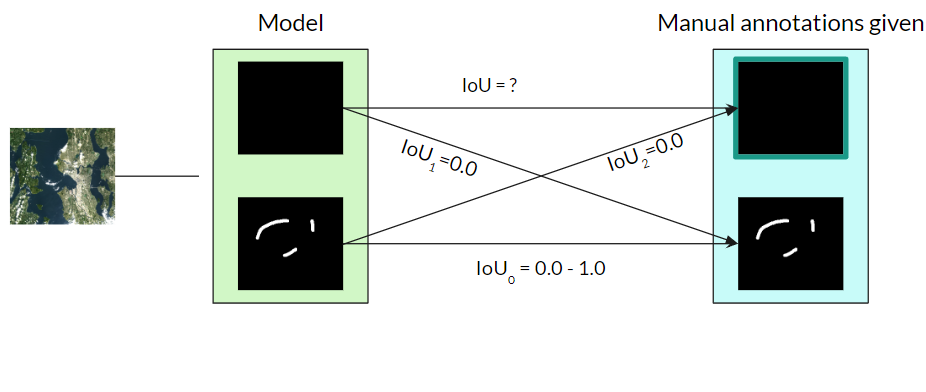

In [38]:
iou_0= np.array([])  # actual mask present and fire pixels detected 
iou_1 = np.array([]) # actual mask present and no fire pixel detected
iou_2= np.array([]) # actual mask not present and fire pixels detected

tn, fp, fn, tp= np.array([]),np.array([]),np.array([]),np.array([])
patch_path= "/content/drive/MyDrive/testing/manually_annotated/patches/landsat_patches"

patch_list= [i for i in os.listdir(patch_path) if i.endswith(".tif")]
print(len(patch_list))

9044


In [ ]:
from tqdm import tqdm


for index, _ in enumerate(tqdm(patch_list)):
    a= _.split("_")
    pathrow, subscene= a[2], a[-1][0:-4]
    date_cap, date_pro= a[3], a[4]
    p_level= a[1]


    img= process_image(rasterio.open(os.path.join(patch_path, _)).read(channel_index).transpose((1, 2, 0)))   
    
    gen_mask= model(img).numpy().squeeze()
    gen_mask= gen_mask > TH_FIRE
    fire_pixels= np.count_nonzero(gen_mask)
    
    if pathrow in manual_masks: # fire in some subscene in whole pathrow
        
        if subscene in manual_masks[pathrow]: # actual fire present for this subscene
            actual_mask_path= os.path.join(manual_path, f"LC08_{p_level}_{pathrow}_{date_cap}_{date_pro}_01_RT_v1_{subscene}.tif")
            actual_mask= rasterio.open(actual_mask_path).read().transpose((1, 2, 0)).squeeze() 
            if fire_pixels == 0: # no fire detected by model
                iou_1 = np.append(iou_1, 0.0)
                tp = np.append(tp, 0.0)
                fp = np.append(fp, 0.0)
                fn = np.append(fn, np.count_nonzero(actual_mask))

            else: # model detected fire
                iou_0= np.append(iou_0, jaccard_index(gen_mask, actual_mask))
                tn1, fp1, fn1, tp1= confusion_matrix(actual_mask.flatten(), gen_mask.flatten()).ravel()
#                 tp1, fp1, fn1= float(conf_mat[1,1]), float(conf_mat[0,1]), float(conf_mat[1,0])
                tp = np.append(tp, tp1)
                fp = np.append(fp, fp1)
                fn = np.append(fn, fn1)
                del actual_mask, actual_mask_path, tp1, fp1, fn1

        else: # no actual fire
            if fire_pixels > 0: # fire detected by model
                iou_2 = np.append(iou_2, 0.0)
                tp = np.append(tp, 0.0)
                fp = np.append(fp, fire_pixels)
                fn = np.append(fn, 0.0)
                
    else: # no actual fire
        if fire_pixels > 0: # fire detected by model
            iou_2 = np.append(iou_2, 0.0)
            tp = np.append(tp, 0.0)
            fp = np.append(fp, fire_pixels)
            fn = np.append(fn, 0.0)

    del a, img, gen_mask, fire_pixels
    
    gc.collect()
    
else:
    print("ALL DONE!!")



 39%|███▉      | 3524/9044 [1:17:34<1:06:59,  1.37it/s]

In [ ]:
print(len(iou_0), len(iou_1), len(iou_2))
print(iou_0.mean())

In [ ]:
print(len(tp), len(fp), len(fn))

In [ ]:
tp1= tp.sum()
fp1= fp.sum()
fn1= fn.sum()
tn1= tn.sum()

In [ ]:
P= tp1/(tp1+fp1)
print("P", P)
R= tp1/(tp1+fn1)
print("R", R)

In [ ]:
F= 2.0/ ((1/P)+(1/R))
print("F ",F)

In [ ]:
IOU= F/(2-F)
print("IoU", IOU)
IOU= tp1/(tp1+fp1+fn1)
print("IOU", IOU)

<hr style="border:2px solid gray">